<a href="https://colab.research.google.com/github/widyamelia26/Javanese-Letter-Recognition/blob/main/aksara_jawa_VGGNet%20(92%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash

# Check if the dataset already exists
if test -e "aksara-jawa-dataset.zip"; then
    rm -rf aksara-jawa-dataset.zip ./data ./data-test
    kaggle datasets download -d rfahrur6045/aksara-jawa-dataset
    unzip aksara-jawa-dataset.zip
else
    kaggle datasets download -d rfahrur6045/aksara-jawa-dataset
    unzip aksara-jawa-dataset.zip
fi

# Remove unnecessary files
rm -f ./data/LICENSE ./data/LICENSE.md ./data/README.md
rm -f ./data-test/LICENSE ./data-test/LICENSE.md ./data-test/README.md

Dataset URL: https://www.kaggle.com/datasets/rfahrur6045/aksara-jawa-dataset
License(s): unknown

Archive:  aksara-jawa-dataset.zip
  inflating: data-test/ba/test-ba1.png  
  inflating: data-test/ba/test-ba2.png  
  inflating: data-test/ca/test-ca1.png  
  inflating: data-test/ca/test-ca2.png  
  inflating: data-test/ca/test-ca3.png  
  inflating: data-test/ca/test-ca4.png  
  inflating: data-test/da/test-da1.png  
  inflating: data-test/da/test-da2.png  
  inflating: data-test/dha/test-dha1.png  
  inflating: data-test/dha/test-dha2.png  
  inflating: data-test/dha/test-dha3.png  
  inflating: data-test/ga/test-ga1.png  
  inflating: data-test/ga/test-ga2.png  
  inflating: data-test/ga/test-ga3.png  
  inflating: data-test/ha/ha_test1.png  
  inflating: data-test/ha/ha_test2.png  
  inflating: data-test/ha/ha_test3.png  
  inflating: data-test/ha/ha_test4.png  
  inflating: data-test/ha/ha_test5.png  
  inflating: data-test/ja/test-ja1.png  
  inflating: data-test/ja/test-ja2.png  
 

100%|██████████| 193M/193M [00:13<00:00, 15.3MB/s]


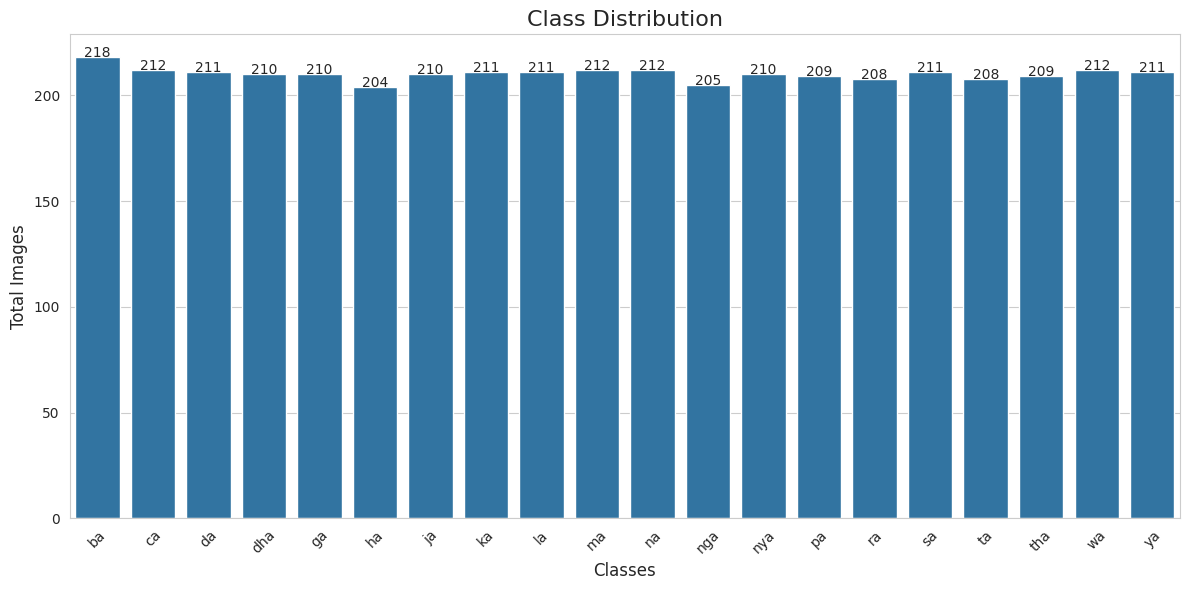

In [ ]:
import glob

import matplotlib.pyplot as plt
import seaborn as sns


train_path = "/content/data"
test_path = "/content/data-test"
class_names = ["ba","ca","da","dha","ga","ha","ja",
               "ka","la","ma","na","nga","nya","pa",
               "ra","sa","ta","tha","wa","ya"]
class_distribution = {}

# Put image paths to dictionary using class names as keys.
for class_name in class_names:
    class_distribution[class_name] = len(glob.glob(f"{train_path}/{class_name}/*"))

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))

plt.title("Class Distribution", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Total Images", fontsize=12)
plt.xticks(rotation=45)

# Add value labels of each bar.
for index, value in enumerate(class_distribution.values()):
    plt.text(index, value, str(value), ha="center", fontsize=10)

plt.tight_layout()
plt.show()

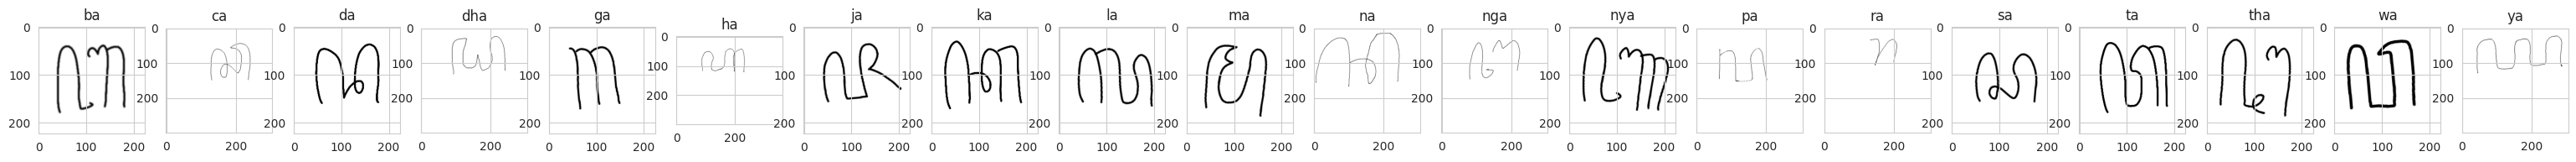

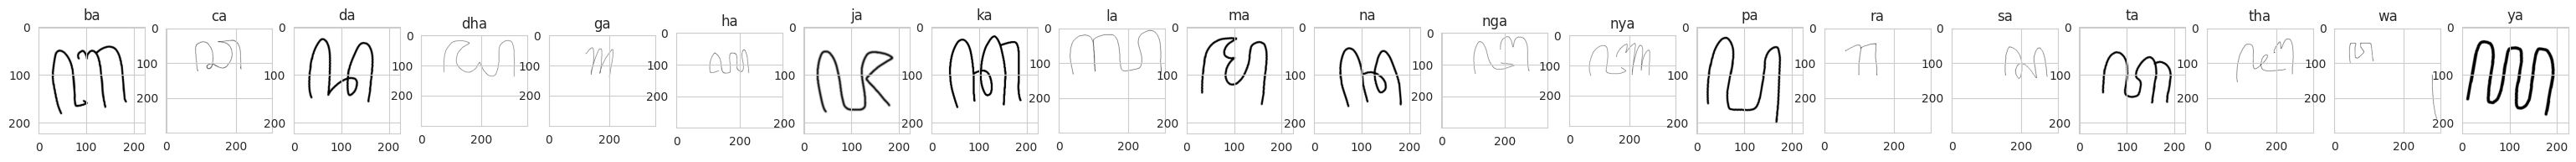

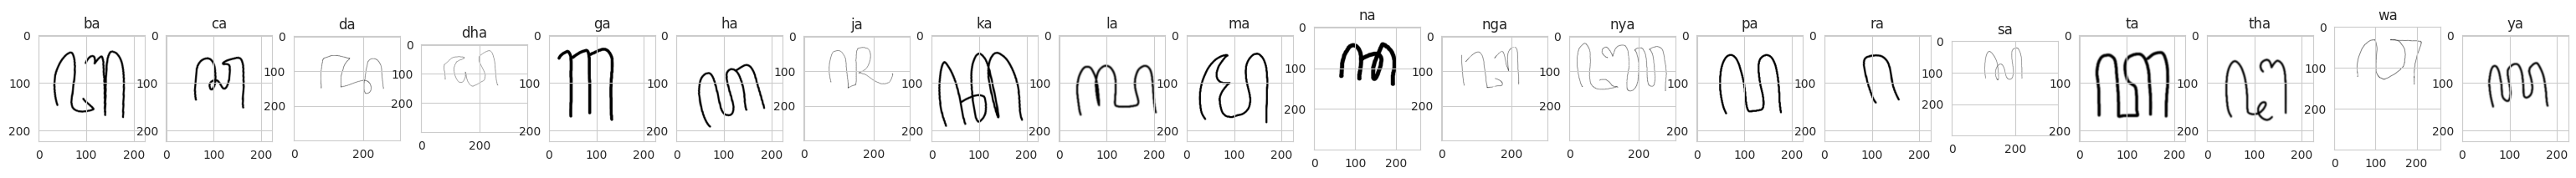

In [ ]:
import cv2
import numpy as np


def plot_sample_images(class_names):
    fig, axis = plt.subplots(1, len(class_names), figsize=[39,45])

    for index, (class_name, count) in enumerate(class_distribution.items()):
        # Randomly choose images to plot.
        random_index = np.random.randint(0, count)
        img_read = cv2.imread(
            glob.glob(f"{train_path}/{class_name}/*")[random_index]
        )

        axis[index].imshow(img_read)
        axis[index].set_title(class_name)

# Plot several samples of each class.
for i in range(0, 3):
    plot_sample_images(class_names)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16


# Data generator for traning and validation.
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode="nearest",
    brightness_range=[0.8, 1.2],
    validation_split=0.2, # 20% of images to be used for validation.
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size=16,
    class_mode="categorical",
    color_mode="rgb",
    subset="training",
    shuffle=True
    )

validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # 20% of images to be used for validation.
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

validation_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size=16,
    class_mode="categorical",
    color_mode="rgb",
    subset="validation",
    shuffle=False
)

Found 3369 images belonging to 20 classes.
Found 834 images belonging to 20 classes.


In [ ]:
# Data generator for evaluation.
test_data_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size=(150,150),
    batch_size=16,
    class_mode="categorical",
    color_mode="rgb",
    shuffle = False  # Keep this False for confusion matrix.
)

Found 55 images belonging to 20 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def create_model(num_classes):
    """
    Create model with enhanced regularization
    """
    # Load VGG16 with batch normalization
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    # Freeze only the first few layers
    for layer in base_model.layers[:15]:
        layer.trainable = False
    for layer in base_model.layers[15:]:
        layer.trainable = True

    # Add custom layers with stronger regularization
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First dense block
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.4)(x)

    # Second dense block
    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

def visualize_model_architecture(model):
    """
    Visualize the model architecture using plot_model
    """
    # Create the model flowchart
    plot_model(
        model,
        to_file='cnn_model.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='LR'
    )

    # Display the flowchart
    plt.figure(figsize=(15, 10))
    img = plt.imread('cnn_model.png')
    plt.imshow(img)
    plt.axis('off')
    plt.title('Model Architecture')
    plt.show()

In [ ]:
def create_callbacks():
    """
    Create enhanced callbacks for better training
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,              # Increased patience
        restore_best_weights=True,
        min_delta=0.001          # Minimum change to qualify as an improvement
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,              # More aggressive LR reduction
        patience=8,              # Reduced patience for LR reduction
        min_lr=1e-7,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    return early_stopping, reduce_lr, checkpoint

def train_model(model, train_generator, validation_generator):
    early_stopping, reduce_lr, checkpoint = create_callbacks()

    # Use a learning rate schedule
    initial_learning_rate = 1e-4
    decay_steps = 1000
    decay_rate = 0.9

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train with class weights if dataset is imbalanced
    history = model.fit(
        train_generator,
        epochs=50,  # Increased epochs since we have better regularization
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr, checkpoint],
    )

    return history

In [ ]:
def fine_tune_model(model, base_model, train_generator, validation_generator):
    early_stopping, reduce_lr, checkpoint = create_callbacks()

    # Fine-tuning with an even lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_fine = model.fit(
        train_generator,
        epochs=30,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr, checkpoint],
    )

    return history_fine

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

In [ ]:
def main(train_generator, validation_generator):
    # Create data generators
    train_generator, validation_generator = train_generator, validation_generator

    # Create model
    num_classes = len(train_generator.class_indices)
    model, base_model = create_model(num_classes)

    # Initial training with frozen base layers
    print("Initial training with frozen base layers...")
    history = train_model(model, train_generator, validation_generator)
    plot_training_history(history)

    # Fine-tuning
    print("Fine-tuning the model...")
    history_fine = fine_tune_model(model, base_model, train_generator, validation_generator)
    plot_training_history(history_fine)


Initial training with frozen base layers...
Epoch 1/50
210/211 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1921 - loss: 3.6612
Epoch 1: val_accuracy improved from -inf to 0.39448, saving model to best_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.1935 - loss: 3.6559 - val_accuracy: 0.3945 - val_loss: 3.1829 - learning_rate: 9.7801e-05
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6900 - loss: 1.9582
Epoch 2: val_accuracy improved from 0.39448 to 0.63429, saving model to best_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - accuracy: 0.6903 - loss: 1.9573 - val_accuracy: 0.6343 - val_loss: 2.2462 - learning_rate: 9.5651e-05
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8648 - loss: 1.4028
Epoch 3: val_accuracy improved from 0.63429 to 0.67146, saving model to best_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - accuracy: 0.8649 - loss: 1.4025 - val_accuracy: 0.6715 - val_loss: 1.9337 - learning_r

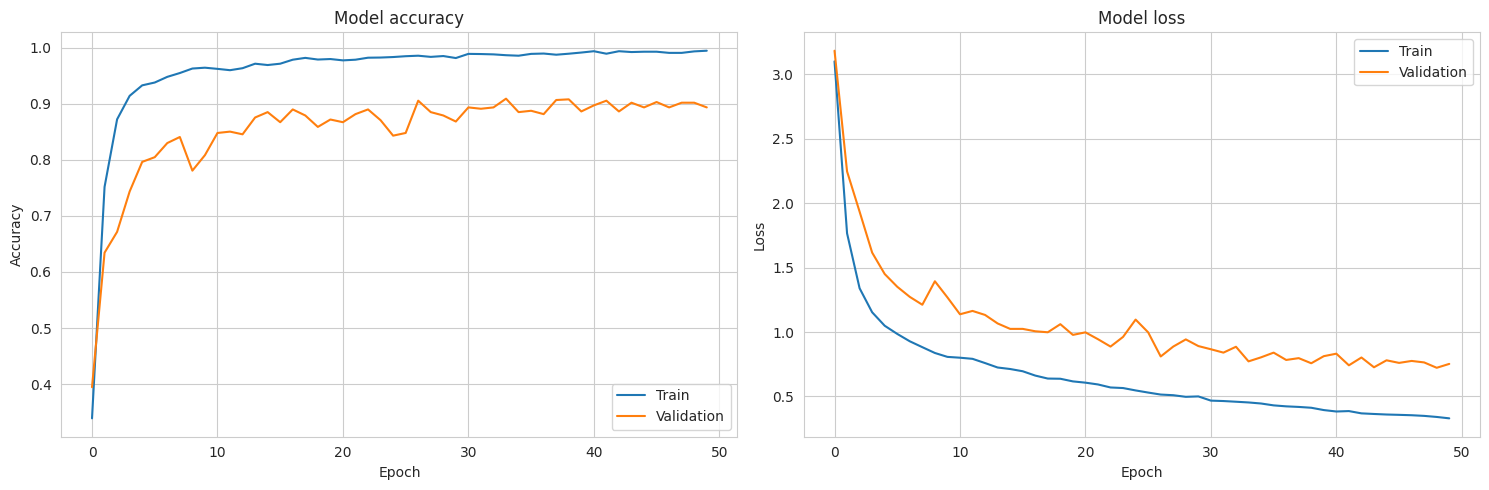

Fine-tuning the model...
Epoch 1/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9925 - loss: 0.3389
Epoch 1: val_accuracy improved from -inf to 0.90048, saving model to best_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 54s 228ms/step - accuracy: 0.9925 - loss: 0.3389 - val_accuracy: 0.9005 - val_loss: 0.6914 - learning_rate: 1.0000e-06
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9986 - loss: 0.3209
Epoch 2: val_accuracy did not improve from 0.90048
211/211 ━━━━━━━━━━━━━━━━━━━━ 37s 172ms/step - accuracy: 0.9986 - loss: 0.3209 - val_accuracy: 0.8933 - val_loss: 0.7146 - learning_rate: 1.0000e-06
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9955 - loss: 0.3274
Epoch 3: val_accuracy improved from 0.90048 to 0.92086, saving model to best_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 47s 199ms/step - accuracy: 0.9955 - loss: 0.3274 - val_accuracy: 0.9209 - val_loss: 0.6771 - learning_rate: 1.0000e-06
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 0

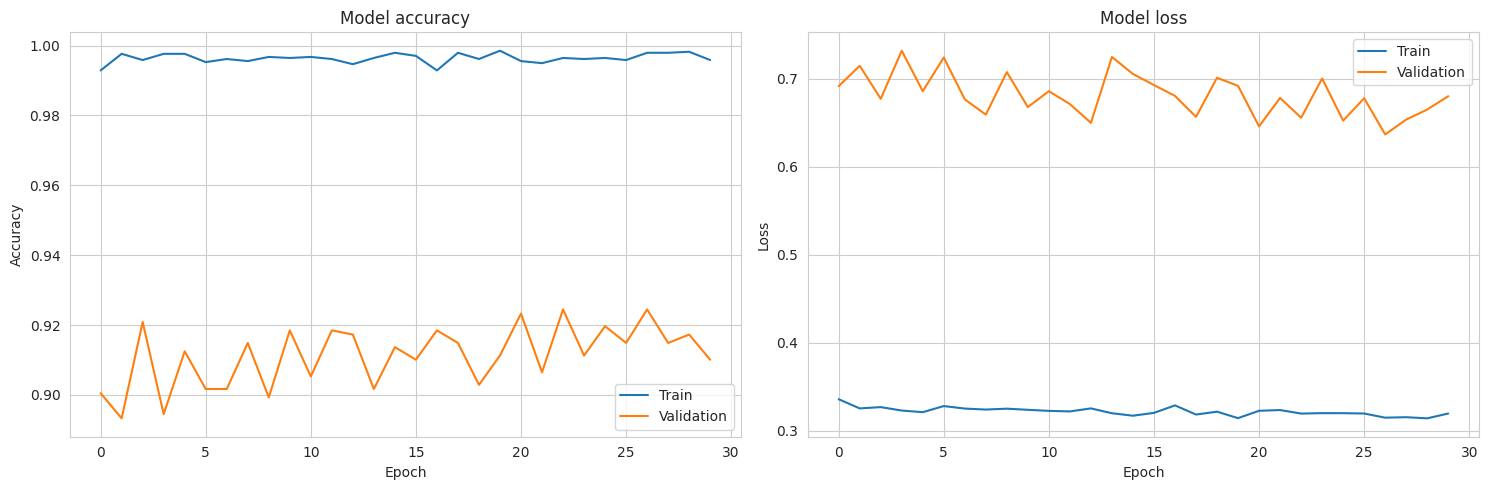

In [ ]:
if __name__ == "__main__":
    main(train_generator, validation_generator)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Nama-nama kelas emosi
class_names = ["ba","ca","da","dha","ga","ha","ja",
               "ka","la","ma","na","nga","nya","pa",
               "ra","sa","ta","tha","wa","ya"]

# Peroleh true labels dari test generator
true_labels = test_generator.classes

# Reset test generator sebelum prediksi
test_generator.reset()

# Dapatkan prediksi model pada data test
predicted = model.predict(test_generator)
predicted_labels = np.argmax(predicted, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()